In [1]:
import corner
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree


- obvi issue
- throughput in bluest end was artifically low, could have been the issue
- could be more than one issue:
- could be the emission lines - next step would be to mask them out, run with spender see if they lie within prospector latent space => more sure that continum can be recovered by prospector
- if that doesn't - start masking
- check the nearest neighbouring prospector spectra as well to the non-overlapping desi spectra

- check redshift distribution of non-overlapping spectra

- that way we can it's due to XYZ
- take the spectra, do a fit to prospector, see if it can recover the spectra, see where it's lacking -> but it's less physical interpretation

In [2]:
from hubersed.style import *
from hubersed.paths import PATHS

DATA_PATH = PATHS['DATA']
RESULTS_PATH = PATHS['RESULTS']

Missing colon in file PosixPath('/Users/ng27753/Astronomy_Research/hubersed/styles/apj.mplstyle'), line 30 ('    \\usepackage{amsmath}')
Missing colon in file PosixPath('/Users/ng27753/Astronomy_Research/hubersed/styles/apj.mplstyle'), line 31 ('    \\usepackage{amssymb}')


In [3]:
rng = np.random.default_rng(42)

In [4]:
device = torch.device('cpu')

In [5]:
# do for spectra
spender_spec = torch.load(DATA_PATH / 'spender_spec_6latent')
s_l = spender_spec['latents'].to(device)
s_zs = spender_spec['zs'].to(device)
s_specs = spender_spec['specs'].to(device)

prospector_spec = torch.load(DATA_PATH / 'prospector_noise_spec_6latent')
p_l = prospector_spec['latents'].to(device)
p_zs = prospector_spec['zs'].to(device)

In [7]:
i, j = 0, 1  # which two latent dimensions to compare

desi_xy = np.column_stack((
    s_l[:, i].detach().cpu().numpy(),
    s_l[:, j].detach().cpu().numpy()
))  # shape [N_desi, 2]

# Prospector (grey)
pros_xy = np.column_stack((
    p_l[:, i].detach().cpu().numpy(),
    p_l[:, j].detach().cpu().numpy()
))  # shape [N_pros, 2]

tree = KDTree(pros_xy)

In [8]:
# For each DESI point, find all Prospector points within radius eps
# ind is a list of index arrays, one per DESI point
dist, ind = tree.query(desi_xy, k=1, return_distance=True)
min_dist = dist[:, 0]

In [9]:
eps = 0.05
non_overlap_mask = min_dist > eps
desi_non_overlap = s_l[non_overlap_mask]

In [10]:
# bin DESI points by distance
bins = np.array([0.01, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0])
bin_idx = np.digitize(min_dist, bins)

In [ ]:
plt.hist(s_zs[non_overlap_mask])

In [ ]:
fig, ax = plt.subplots(1, 1)

sc = ax.scatter(desi_non_overlap[:, i], desi_non_overlap[:, j], s=0.05, c=s_zs[non_overlap_mask])
fig.colorbar(sc, ax=ax, label='z')

ax.set_xticks([])
ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots(1, 1)

sc = ax.scatter(desi_non_overlap[:, i], desi_non_overlap[:, j], s=0.05, c=min_dist[non_overlap_mask])
fig.colorbar(sc, ax=ax, label='dist')

ax.set_xticks([])
ax.set_yticks([])

In [11]:
# choose 3 s_l spectra from each dist bin
bin_idx_non_overlap = bin_idx[non_overlap_mask]

check_desi_idx = []
bs = []

non_overlap_idx = np.where(non_overlap_mask)[0]

for b in np.unique(bin_idx_non_overlap):
    b_mask = bin_idx_non_overlap == b
    b_idx = non_overlap_idx[b_mask]
    
    k = min(3, len(b_idx))
    if k == 0:
        print(f"No points in bin {b}")
        continue

    chosen = rng.choice(b_idx, size=k, replace=False)
    check_desi_idx.append(chosen)
    bs.append([b] * k)

if len(check_desi_idx) > 0:
    chosen_desi_idx = np.concatenate(check_desi_idx)
    bs = np.concatenate(bs)
else:
    chosen_desi_idx = np.array([], dtype=int)
    print("No points to check")

check_desi_latents = s_l[chosen_desi_idx]
check_desi_zs = s_zs[chosen_desi_idx]
check_desi_specs = s_specs[chosen_desi_idx]

In [22]:
from spender import load_model
from spender.data import desi
from hubersed.utils import trapz_rebin

inst = desi.DESI()

model = load_model(str(DATA_PATH / 'spender_asc_run_6latent_zmax.pt'), instrument=inst, map_location=device, weights_only=False)
model.eval()

SpectrumAutoencoder(
  (encoder): SpectrumEncoder(
    (instrument): DESI()
    (conv1): Sequential(
      (0): Conv1d(1, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=128)
      (3): Dropout(p=0, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv1d(128, 256, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=256)
      (3): Dropout(p=0, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv1d(256, 512, kernel_size=(21,), stride=(1,), padding=(10,))
      (1): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): PReLU(num_parameters=512)
      (3): Dropout(p=0, inplace=False)
    )
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=2, dilation=1, ceil_mode=False)
    

In [24]:
wave_obs = model.wave_obs
wave_rest = model.wave_rest
wave_rebin = np.arange(model.wave_obs[0], model.wave_obs[-1], 10)[1:-1]

/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_35204/2883267717.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  wave_rebin = np.arange(model.wave_obs[0], model.wave_obs[-1], 10)[1:-1]


/var/folders/4v/k4xpjdyx3f1_c95lc_dlyhkr0000gq/T/ipykernel_35204/734373886.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  spec_rebin = trapz_rebin(np.array(model.wave_obs), np.array(check_desi_specs[idx].cpu()), xnew=wave_rebin)


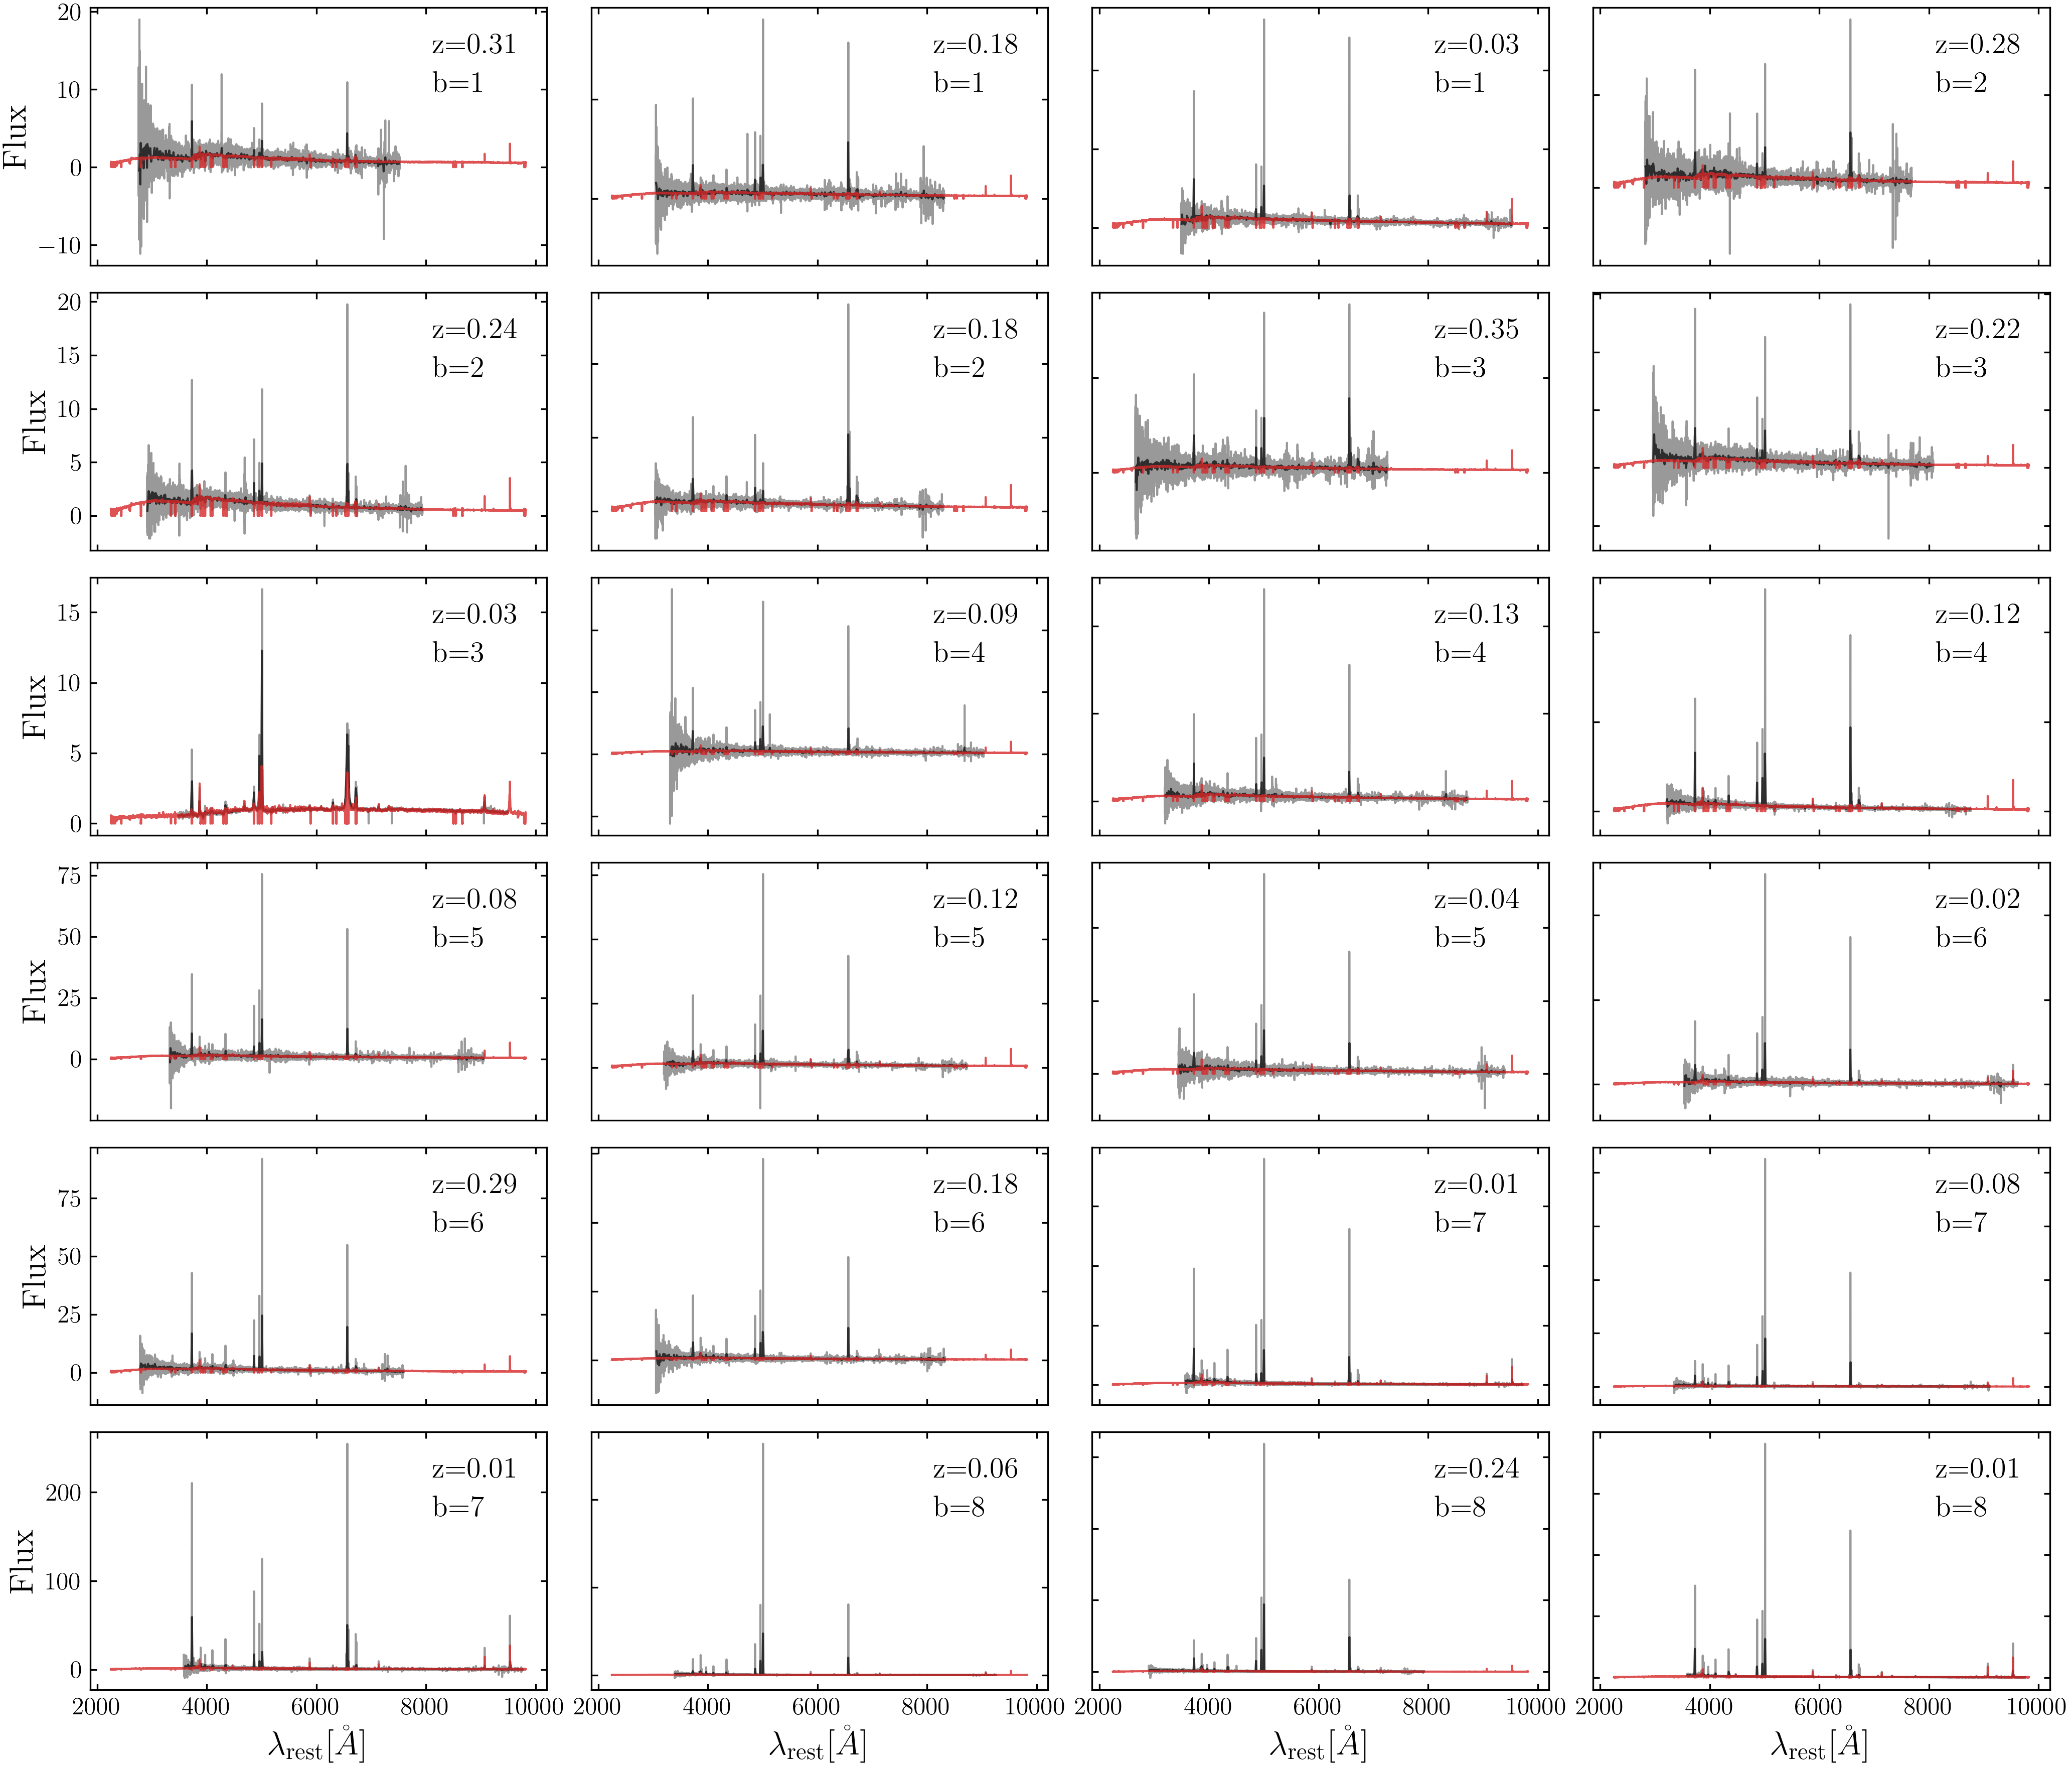

In [ ]:
fig, ax = plt.subplots(6, 4, figsize=(14, 12), sharex=True)
ax = ax.flatten()

for idx, (latent, z) in enumerate(zip(check_desi_latents, check_desi_zs)):
    with torch.no_grad():
        desi_spec_decode = model.decode(latent)
    
    ax[idx].plot(wave_obs / (1 + z), check_desi_specs[idx].cpu(), color='gray', alpha=0.8, label='_desi_obs')

    spec_rebin = trapz_rebin(np.array(model.wave_obs), np.array(check_desi_specs[idx].cpu()), xnew=wave_rebin)
    ax[idx].plot(wave_rebin / (1.0 + z), spec_rebin, color='k', alpha=0.7, label='_desi_obs_rebin')
    
    # ax[idx].plot(wave_rest, desi_spec_decode, color='C1', alpha=0.8, label='_desi_spender_decode')
    # ax[idx].plot(wave_rest, decodes_em_mask[idx].cpu(), color='C3', alpha=0.8, label='_desi_spender_decode_em_mask')

    ax[idx].text(0.75, 0.9, f'z={z:.2f}', transform=ax[idx].transAxes, fontsize=14, verticalalignment='top')
    ax[idx].text(0.75, 0.75, f'b={bs[idx]}', transform=ax[idx].transAxes, fontsize=14, verticalalignment='top')
    
    ax[idx].set_ylabel('Flux', fontsize=16)
    ax[idx].set_xlabel(r'$\lambda_{\rm {rest}} [\AA]$', fontsize=16)
    ax[idx].label_outer()

    ax[idx].tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()
fig.legend(['DESI', 'DESI Rebin', 'Spender Decode'], loc='upper center', ncol=3, fontsize=16, bbox_to_anchor=(0.5, 1.02))
# fig.legend(['DESI', 'DESI Rebin', 'Spender Decode', 'Spender Decode EM Mask'], loc='upper center', ncol=4, fontsize=16, bbox_to_anchor=(0.5, 1.02))

fig.savefig(RESULTS_PATH / 'desi_spectra_outlier_check.pdf', dpi=300)